# XGBoost Model

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Step1 Data loading

In [2]:
store = pd.read_csv('../data/preprocessed_store.csv')
train = pd.read_csv('../data/preprocessed_train.csv', index_col='Date', parse_dates=True)
test = pd.read_csv('../data/preprocessed_test.csv')
train.shape, test.shape, store.shape

C:\Users\gejunkai\AppData\Local\Temp\ipykernel_5644\1384424085.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../data/preprocessed_train.csv', index_col='Date', parse_dates=True)


((1017209, 8), (41088, 8), (1115, 10))

In [3]:
# Merge train data with store data
train_store_joined = train.merge(store, on='Store', how='left')

# Ensure the index is a DatetimeIndex
if not isinstance(train_store_joined.index, pd.DatetimeIndex):
    train_store_joined.index = pd.to_datetime(train_store_joined.index)

# Extract Year, Month, WeekofYear from the date index
train_store_joined['Year'] = train_store_joined.index.year
train_store_joined['Month'] = train_store_joined.index.month
train_store_joined['WeekofYear'] = train_store_joined.index.isocalendar().week

## Step2 Data Preprocessing

In [5]:
# Drop unnecessary columns
ts_xgboost = train_store_joined.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'PromoInterval'], axis=1)

# Combine similar columns into one and drop old columns
ts_xgboost['CompetitionOpen'] = 12 * (ts_xgboost['Year'] - ts_xgboost['CompetitionOpenSinceYear']) + (ts_xgboost['Month'] - ts_xgboost['CompetitionOpenSinceMonth'])
ts_xgboost['PromoOpen'] = 12 * (ts_xgboost['Year'] - ts_xgboost['Promo2SinceYear']) + (ts_xgboost['WeekofYear'] - ts_xgboost['Promo2SinceWeek']) / 4.0

# Drop old columns
ts_xgboost = ts_xgboost.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceWeek", "Promo2SinceYear"], axis=1)

# Map categorical variables to numerical
mappings = {0: 0, "0": 0, "a": 1, "b": 1, "c": 1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)

# Drop original categorical columns
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis=1)

## Step3 Separate features

In [6]:
features = ts_xgboost.drop(["Sales"], axis=1)
target = ts_xgboost["Sales"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)


## Step4 Train the model for the first time

In [7]:
params = {'max_depth': 6, 'booster': "gbtree", 'eta': 0.3, 'objective': 'reg:squarederror'} 

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

# Monitor training and validation performance
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Train the model
xgboost = xgb.train(params, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10, verbose_eval=True)

# Predict the test set
preds = xgboost.predict(dtest)

# Calculate RMSE metric
rms_xgboost = sqrt(mean_squared_error(y_test, preds))
print(f"RMSE of the XGBoost model: {rms_xgboost:.4f}")

[0]	train-rmse:3217.91583	eval-rmse:3212.33027
[1]	train-rmse:2851.17097	eval-rmse:2847.00726
[2]	train-rmse:2638.13376	eval-rmse:2634.24265
[3]	train-rmse:2522.25328	eval-rmse:2519.67661
[4]	train-rmse:2454.93079	eval-rmse:2452.43361
[5]	train-rmse:2405.38850	eval-rmse:2403.78875
[6]	train-rmse:2377.09424	eval-rmse:2375.96569
[7]	train-rmse:2361.48649	eval-rmse:2360.47246
[8]	train-rmse:2337.42687	eval-rmse:2337.72298
[9]	train-rmse:2286.66927	eval-rmse:2287.37833
[10]	train-rmse:2263.08373	eval-rmse:2263.69922
[11]	train-rmse:2250.13253	eval-rmse:2250.32133
[12]	train-rmse:2216.30420	eval-rmse:2217.27893
[13]	train-rmse:2201.56665	eval-rmse:2202.29240
[14]	train-rmse:2172.15456	eval-rmse:2172.15775
[15]	train-rmse:2147.13042	eval-rmse:2147.31219
[16]	train-rmse:2118.96876	eval-rmse:2119.36173
[17]	train-rmse:2104.04091	eval-rmse:2104.34381
[18]	train-rmse:2059.10172	eval-rmse:2059.70024
[19]	train-rmse:2042.20427	eval-rmse:2043.33738
[20]	train-rmse:2033.59387	eval-rmse:2035.12551
[2

## Step5 Retrain the model

In [10]:
params_2 = {'max_depth': 10, 'eta': 0.1, 'gamma': 2, 'objective': 'reg:squarederror'}

# Retrain the model with new parameters
xgboost_2 = xgb.train(params_2, dtrain, num_boost_round=100, evals=watchlist, early_stopping_rounds=10, verbose_eval=True)

# Predict again
preds_2 = xgboost_2.predict(dtest)

# Calculate the adjusted RMSE
rms_xgboost_2 = sqrt(mean_squared_error(y_test, preds_2))
print(f"Adjusted RMSE of the XGBoost model: {rms_xgboost_2:.4f}")

[0]	train-rmse:3594.11733	eval-rmse:3589.25355
[1]	train-rmse:3370.13411	eval-rmse:3366.00456
[2]	train-rmse:3168.24082	eval-rmse:3164.48210
[3]	train-rmse:2994.08487	eval-rmse:2990.55865
[4]	train-rmse:2843.40471	eval-rmse:2840.76934
[5]	train-rmse:2712.62922	eval-rmse:2710.42867
[6]	train-rmse:2597.41796	eval-rmse:2596.02640
[7]	train-rmse:2495.80118	eval-rmse:2495.40169
[8]	train-rmse:2400.49272	eval-rmse:2400.82709
[9]	train-rmse:2327.15388	eval-rmse:2327.87544
[10]	train-rmse:2262.02213	eval-rmse:2263.71210
[11]	train-rmse:2206.56418	eval-rmse:2208.66429
[12]	train-rmse:2149.26029	eval-rmse:2151.92031
[13]	train-rmse:2106.11956	eval-rmse:2109.03023
[14]	train-rmse:2070.04889	eval-rmse:2073.44925
[15]	train-rmse:2033.37825	eval-rmse:2036.61145
[16]	train-rmse:2004.06899	eval-rmse:2008.10331
[17]	train-rmse:1973.10083	eval-rmse:1977.32157
[18]	train-rmse:1947.54282	eval-rmse:1951.92595
[19]	train-rmse:1927.09955	eval-rmse:1931.87152
[20]	train-rmse:1908.18030	eval-rmse:1913.19584
[2

## Step6 Feature importance analysis

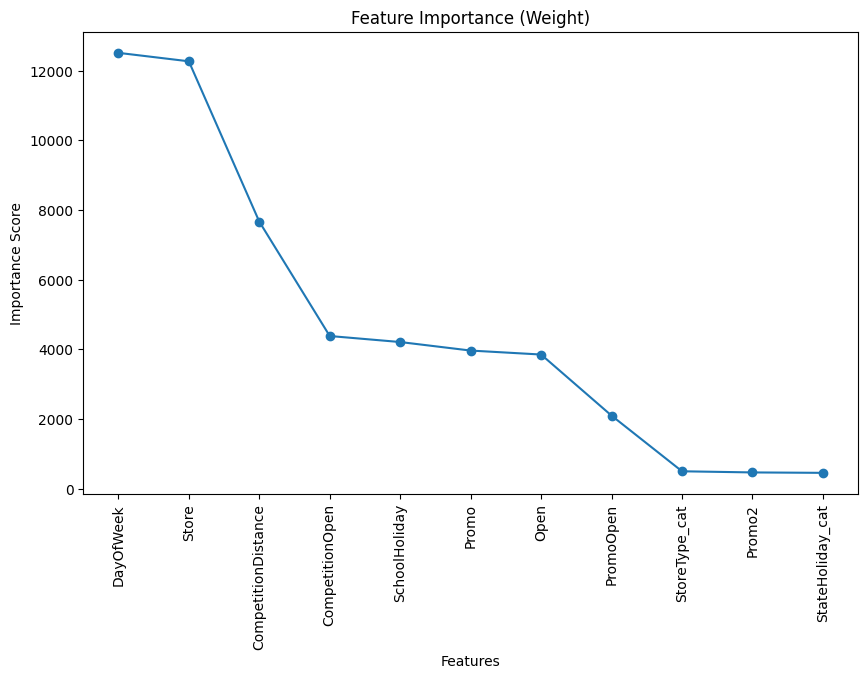

In [23]:
# 1. Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
importance = xgboost_2.get_score(importance_type='weight')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
keys = [k for k, v in importance]
values = [v for k, v in importance]
ax.plot(keys, values, marker='o')
plt.xticks(rotation=90)
plt.title('Feature Importance (Weight)')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

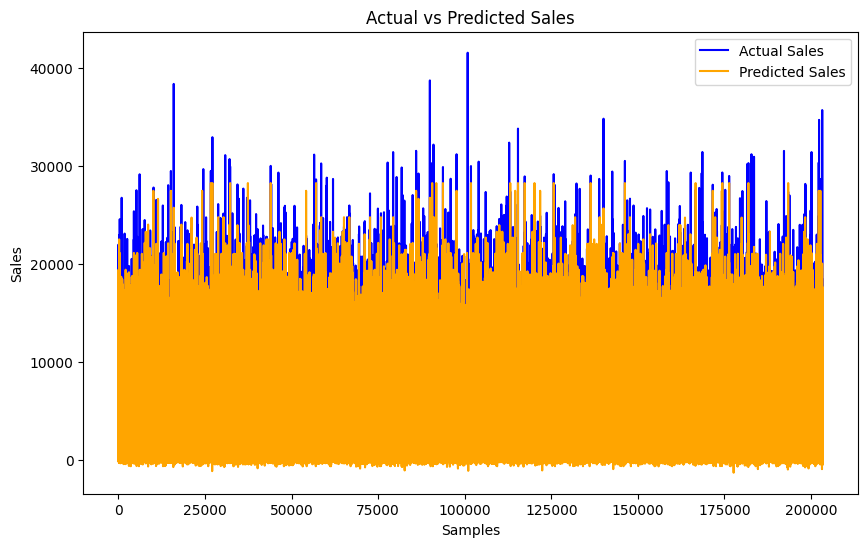

In [24]:
# 2. Predicted vs Actual Sales as Line Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales', color='blue')
plt.plot(preds_2, label='Predicted Sales', color='orange')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

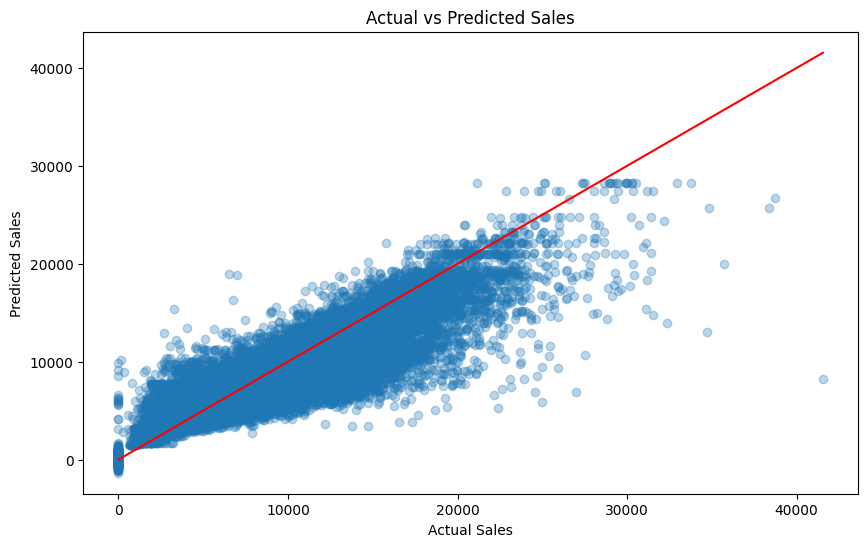

In [25]:
# 3. Predicted vs Actual Sales as Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds_2, alpha=0.3)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.show()

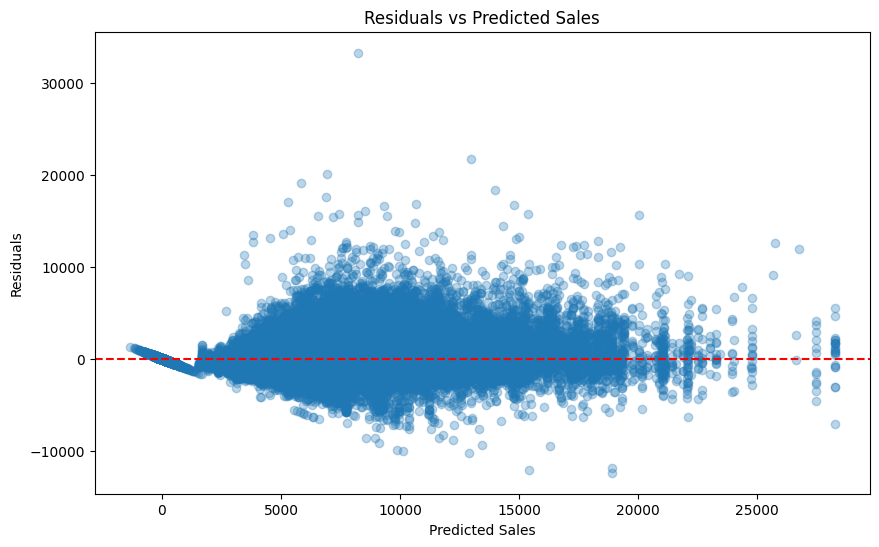

In [26]:
# 4. Residual Plot
residuals = y_test - preds_2
plt.figure(figsize=(10, 6))
plt.scatter(preds_2, residuals, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Sales')
plt.show()

## Step7 Result

In [32]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, preds_2)
print(f"MSE: {mse:.4f}")

# Root Mean Squared Error (RMSE)
rmse = sqrt(mse)
print(f"RMSE: {rmse:.4f}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, preds_2)
print(f"MAE: {mae:.4f}")


MSE: 1592465.3362
RMSE: 1261.9292
MAE: 807.5028
